# 1. Loading Pre-Trained BERT

In [1]:
!pip install transformers

In [3]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt


# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# 2.2. Tokenization

In [4]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [5]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [6]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


# 2.3. Segment ID

In [7]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# 3. Extracting Embeddings
## 3.1. Running BERT on our text

In [8]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [9]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [10]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on
    # how it's  configured in the `from_pretrained` call earlier. In this case,
    # becase we set `output_hidden_states = True`, the third item will be the
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

# 3.2. Understanding the Output


In [11]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


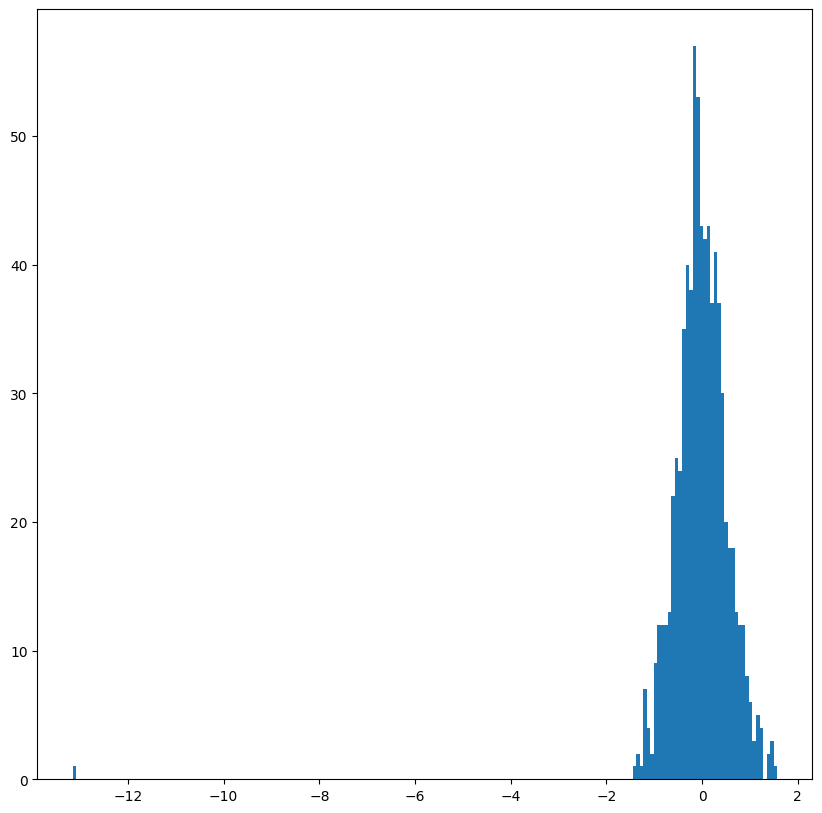

In [12]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [13]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [14]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [15]:
torch.Size([13, 1, 22, 768])

torch.Size([13, 1, 22, 768])

In [16]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [17]:
torch.Size([13, 22, 768])

torch.Size([13, 22, 768])

In [18]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

## 3.3. Creating word and sentence vectors from hidden states

In [20]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


Alternative

In [27]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))


Shape is: 22 x 768


In [26]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [22]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


## 3.4. Confirming contextually dependent vectors


In [23]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [28]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5267, -0.8895, -0.5152, -0.9298,  2.8334])


In [29]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
